In [1]:
from LegoRL import *

In [2]:
import gym
env = gym.make("Pendulum-v0")

In [3]:
import torch
import torch.nn as nn

PendulumNN = lambda input_size, output_size: nn.Sequential(
                nn.Linear(input_size, 128),
                nn.ReLU(),
                nn.Linear(128, 128),
                nn.ReLU(),
                nn.Linear(128, output_size)
)

# Proximal Policy Optimization

In [4]:
class PPO(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.runner            = Runner(self)
        self.state_norm        = StateNormalizer(self)
        self.rew_norm          = RewardNormalizer(self)
        self.rollout_collector = RolloutCollector(self, rollout_length=2048)
        self.epoched_sampler   = EpochedRollout(self, epochs=10, batch_size=64)
        
        self.backbone     = Model(self, PendulumNN, output=Embedding(128))
        self.policy       = PolicyNetwork(self, input=Embedding(128))
        self.critic       = VNetwork(self, input=Embedding(128))
        
        self.gae          = GAE(self, tau=0.95)
        self.centered     = AdvantageNormalizer(self)
        
        self.actor_loss   = ProximalLoss(self)
        self.critic_loss  = ProximalCriticLoss(self, weight=0.5)
        self.entropy_loss = EntropyLoss(self, weight=0.01)
        self.trainer      = Trainer(self, models=[self.backbone, self.policy, self.critic],
                                         optimizer_args={"lr": 3e-4}, 
                                         clip_gradients=0.5)
        
    def act(self, states, *args, **kwargs):
        norm_states = self.state_norm.apply(states)
        embedding = self.backbone(norm_states)
        policy = self.policy(embedding)
        return Storage(actions=policy.sample(), policy=policy)
        
    def iteration(self):
        batch = self.epoched_sampler.sample_next()
        
        if batch is None:
            # collecting data stage
            with torch.no_grad():
                # normalizing states
                self.state_norm.update(self.runner.states)
                norm_states = self.state_norm.apply(self.runner.states)
                
                # forward pass through network
                embedding = self.backbone(norm_states)
                policy = self.policy(embedding)
                V = self.critic(embedding)
                actions = policy.sample()
                
                # collecting transition
                transition = self.runner.step(actions)        
                
                # normalizing reward
                self.rew_norm.update(self.runner.disc_R)
                norm_rewards = self.rew_norm.apply(transition.rewards)
                
                # collecting rollouts
                transition = Storage(norm_states=norm_states,
                                     actions=actions, 
                                     policy=policy, 
                                     V=V, 
                                     norm_rewards=norm_rewards, 
                                     discounts=transition.discounts)
            
                dataset = self.rollout_collector.add(transition)
                if dataset:
                    # compute GAE advantages
                    norm_next_states = self.state_norm.apply(self.runner.states)
                    last_embedding = self.backbone(norm_next_states)
                    last_V = self.critic(last_embedding)  
                    adv = self.gae(dataset.norm_rewards, dataset.V, dataset.discounts, last_V)
                    
                    # store dataset
                    self.epoched_sampler.new_dataset(Storage(norm_states=dataset.norm_states, 
                                                             actions=dataset.actions, 
                                                             old_policy=dataset.policy, 
                                                             old_V = dataset.V, 
                                                             adv = adv))
        else:
            # forward pass
            embedding = self.backbone(batch.norm_states)
            policy = self.policy(embedding)
            V = self.critic(embedding)
            
            # compute targets
            target_V = batch.adv.add_v(batch.old_V)
            centered_adv = self.centered(batch.adv)
            
            # optimize
            loss1 = self.actor_loss(policy, batch.old_policy, batch.actions, centered_adv)
            loss2 = self.critic_loss(V, batch.old_V, target_V)
            loss3 = self.entropy_loss(policy)  # for logs only
            
            self.trainer.optimize(loss1 + loss2)

In [5]:
ppo = PPO(env=env, gamma=0.99)
vis = Visualizer(ppo, timer=1000)

Initializing <Model>:
  Input shape is torch.Size([3])
  Output shape is torch.Size([128])
Initializing <PolicyNetwork>:
  Input shape is torch.Size([128])
  Output shape is torch.Size([2, 1])
Initializing <VNetwork>:
  Input shape is torch.Size([128])
  Output shape is torch.Size([])


In [6]:
ppo

<Runner>: Makes steps in 1 parallel environments
<StateNormalizer>: Normalizes observations
<RewardNormalizer>: Normalizes returns
<RolloutCollector>: Collects rollouts of length 2048
<EpochedRollout>: Performs 10 epoches with batches of size 64 on provided dataset
<Model>: Models Embedding of size 128
<PolicyNetwork>: Models Gaussian Policy
<VNetwork>: Models V-function
<GAE>: Estimates GAE advantages
<AdvantageNormalizer>: Normalizes advantages in the batch to zero mean and unit std
<ProximalLoss>: Calculates PPO gradient estimation
<ProximalCriticLoss>: Calculates proximal TD loss by clipping prediction when it is far from old prediction
<EntropyLoss>: Calculates entropy penalty
<Trainer>: Standard SGD loss optimization
<Visualizer>: Plots logs every 1000 iteration

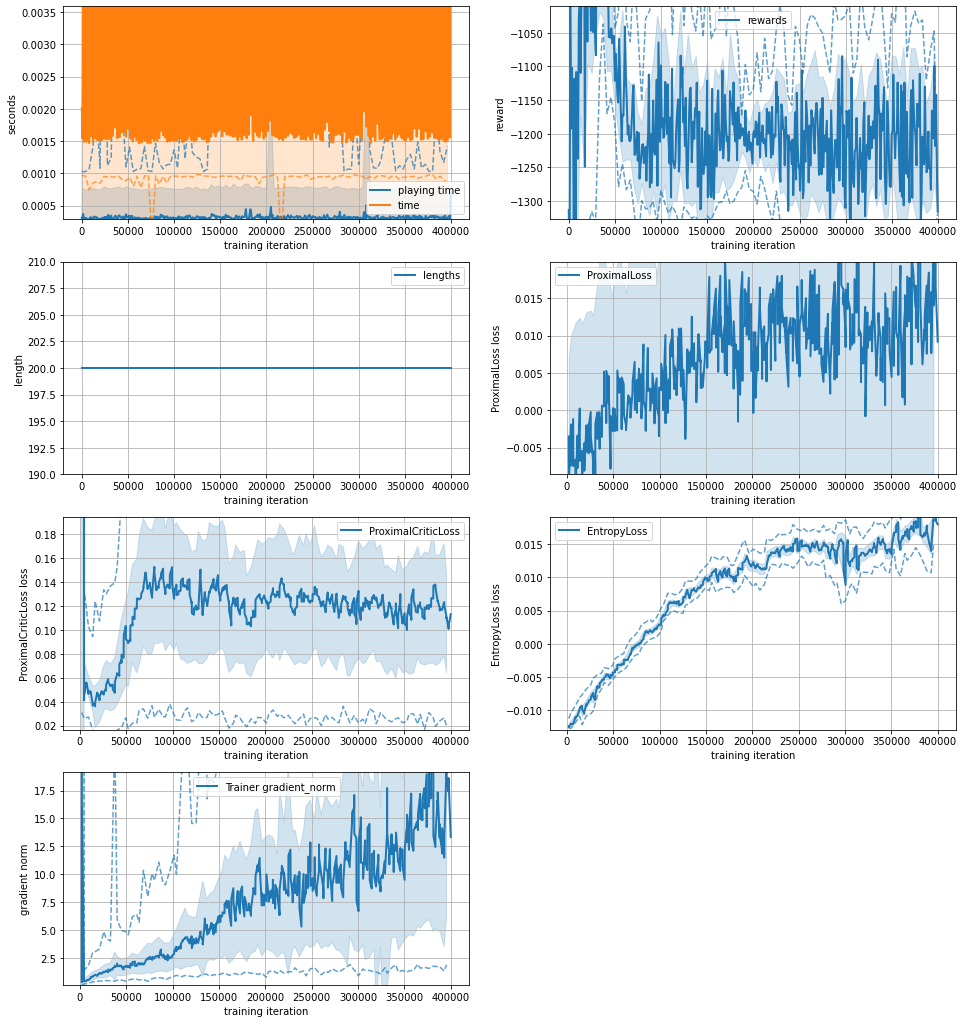

In [7]:
# :(
ppo.run(400000)

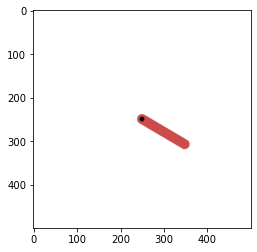

In [8]:
rollout = ppo.runner.play(ppo.act, render=True)

# DDPG

In [7]:
class DDPG(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.runner         = Runner(self)
        self.noise          = OUnoise(self)        
        self.q_network      = ForwardQNetwork(self, PendulumNN)
        self.policy         = PolicyNetwork(self, PendulumNN, output=DeterministicPolicy)
        self.target_network = Frozen(self, self.q_network)
        self.target_policy  = Frozen(self, self.policy)
        self.replay         = ReplayBuffer(self)
        self.sampler        = Sampler(self, self.replay)
        self.loss           = CriticLoss(self)
        self.critic_trainer = Trainer(self, models=self.q_network)
        self.policy_loss    = DeterministicActorLoss(self)
        self.actor_trainer  = Trainer(self, models=self.policy)
    
    def iteration(self):
        # Data collection---------------------------------------------------------------
        with torch.no_grad():
            actions = self.policy(self.runner.states).sample()
            actions = self.noise(actions, self.runner.is_start)

            transition = self.runner.step(actions)
            self.replay.store(transition)
        
        # Training ---------------------------------------------------------------------
        batch = self.sampler.sample()
        if batch:
            # Actor
            new_actions = self.policy(batch.states).rsample()
            V = self.q_network(batch.states, new_actions)
            loss = self.policy_loss(V)
            self.actor_trainer.optimize(loss)

            # Critic
            with torch.no_grad():
                next_actions = self.target_policy(batch.next_states).sample()
                next_V = self.target_network(batch.next_states, next_actions)
                target = next_V.one_step(batch.rewards, batch.discounts)
            
            prediction = self.q_network.Q(batch.states, batch.actions)
            loss = self.loss(prediction, target)
            self.critic_trainer.optimize(loss)
            
        # Target network update --------------------------------------------------------
        self.target_network.update()
        self.target_policy.update()

In [8]:
ddpg = DDPG(env)
visualizer = Visualizer(ddpg)

Initializing <ForwardQNetwork>:
  Input shapes:
    torch.Size([3])
    torch.Size([1])
  Output shape is torch.Size([])
Initializing <PolicyNetwork>:
  Input shape is torch.Size([3])
  Output shape is torch.Size([1])


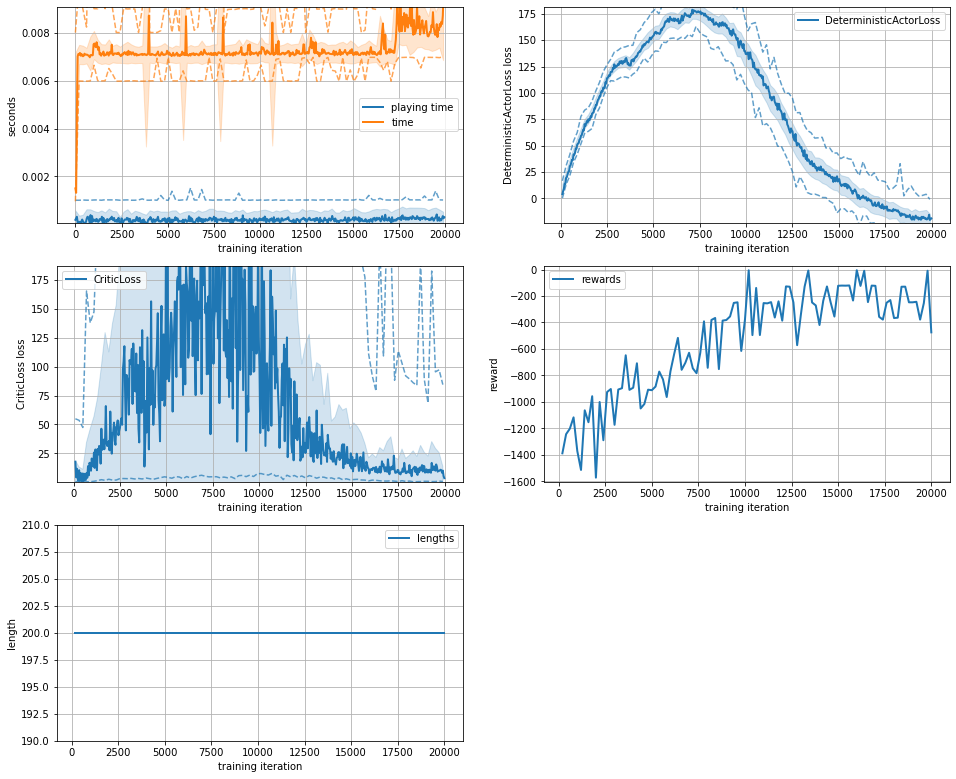

In [9]:
ddpg.run(20000)

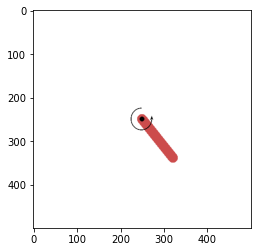

In [10]:
ddpg.runner.play(ddpg.policy.act, render=True);

In [11]:
ddpg.runner.fps

136.79923975011278

# TD3

In [4]:
class Critic(RLmodule):
    def __init__(self, par):
        super().__init__(par)
        
        self.q_network      = ForwardQNetwork(self, PendulumNN)
        self.target_network = Frozen(self, self.q_network, SoftUpdate())
        self.loss           = CriticLoss(self)
        self.trainer        = Trainer(self, models=self.q_network)
        
    def train(self, batch, target):
        prediction = self.q_network.Q(batch.states, batch.actions)
        loss = self.loss(prediction, target)
        self.trainer.optimize(loss)
        
        self.target_network.update()

In [19]:
class Actor(RLmodule):
    def __init__(self, par, K = 2):
        super().__init__(par)
        
        self.K = K
        
        self.policy         = PolicyNetwork(self, PendulumNN, output=DeterministicPolicy)        
        self.target_policy  = Frozen(self, self.policy, SoftUpdate())     
        self.clipped_noise  = ClippedNoise(self)
        self.policy_loss    = DeterministicActorLoss(self)
        self.actor_trainer  = Trainer(self, models=self.policy)
        
    def train(self, batch, critic):
        if self.system.iterations % self.K == 0:
            new_actions = self.policy(batch.states).rsample()
            V = critic(batch.states, new_actions)
            loss = self.policy_loss(V)
            self.actor_trainer.optimize(loss)
        
        self.target_policy.update()
        
    def target_act(self, next_states):
        with torch.no_grad():
            next_actions = self.target_policy(next_states).sample()
            return self.clipped_noise(next_actions)
            
    def hyperparameters(self):
        hp = super().hyperparamters()
        hp.update("DelayedPolicyTraining", self.K)
        return hp

In [23]:
from LegoRL.models.frozen import SoftUpdate

class TD3(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.runner         = Runner(self)
        self.noise          = OUnoise(self)
        self.actor          = Actor(self)          
        self.critic1        = Critic(self)       
        self.critic2        = Critic(self) 
        self.twin           = Twin(self)
        self.replay         = ReplayBuffer(self)
        self.sampler        = Sampler(self, self.replay)        
        
    def target(self, batch):
        with torch.no_grad():
            # Creating target for critic
            next_actions = self.actor.target_act(batch.next_states)
            next_V1 = self.critic1.target_network(batch.next_states, next_actions)
            next_V2 = self.critic2.target_network(batch.next_states, next_actions)
            return self.twin(next_V1, next_V2).one_step(batch.rewards, batch.discounts)
    
    def iteration(self):
        # Data collection---------------------------------------------------------------
        with torch.no_grad():
            actions = self.actor.policy(self.runner.states).sample()
            actions = self.noise(actions, self.runner.is_start)

            transition = self.runner.step(actions)
            self.replay.store(transition)
        
        # Training ---------------------------------------------------------------------
        batch = self.sampler.sample()
        if batch:
            # Actor
            self.actor.train(batch, self.critic1.q_network)

            # Critic 1
            target = self.target(batch)            
            self.critic1.train(batch, target)
        
        # Critic 2; other batch
        batch = self.sampler.sample()
        if batch:
            target = self.target(batch)            
            self.critic2.train(batch, target)

In [24]:
td3 = TD3(env)
visualizer = Visualizer(td3)

Initializing <PolicyNetwork>:
  Input shape is torch.Size([3])
  Output shape is torch.Size([1])
Initializing <ForwardQNetwork>:
  Input shapes:
    torch.Size([3])
    torch.Size([1])
  Output shape is torch.Size([])
Initializing <ForwardQNetwork>:
  Input shapes:
    torch.Size([3])
    torch.Size([1])
  Output shape is torch.Size([])


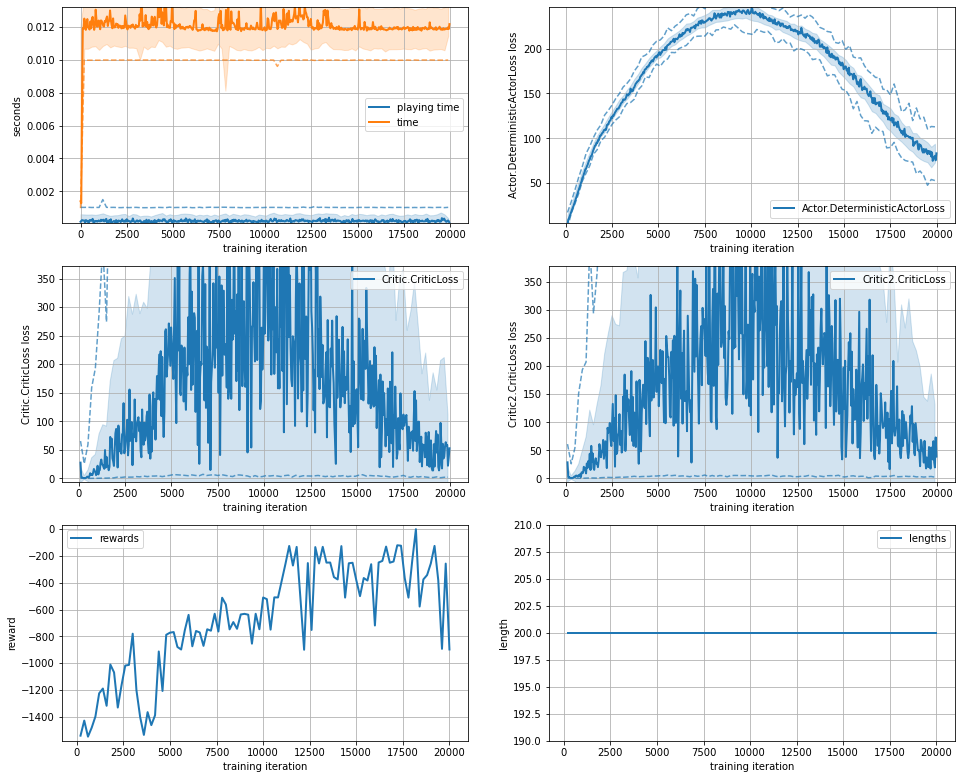

In [25]:
td3.run(20000)

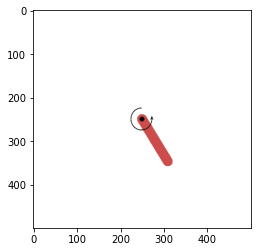

In [26]:
td3.runner.play(td3.actor.policy.act, render=True);

In [27]:
td3.runner.fps

82.87658100307027

# SAC

In [35]:
class Critic(RLmodule):
    def __init__(self, par):
        super().__init__(par)
        
        self.q_network      = ForwardQNetwork(self, PendulumNN)
        self.target         = OneStep(self)
        self.loss           = CriticLoss(self)
        self.trainer        = Trainer(self, models=self.q_network)
        
    def train(self, batch, target_network):
        target = self.target(target_network, **batch)
        prediction = self.q_network.Q(batch.states, batch.actions)
        loss = self.loss(prediction, target)
        self.trainer.optimize(loss)

In [39]:
class SAC(System):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.runner         = Runner(self) 
        self.replay         = ReplayBuffer(self)
        self.sampler        = Sampler(self, self.replay)  
        
        self.critic1        = Critic(self)      
        self.critic2        = Critic(self)
        
        self.v_network      = VNetwork(self, PendulumNN)
        self.target_network = Frozen(self, self.v_network, SoftUpdate())
        self.v_loss         = CriticLoss(self)
        self.v_trainer      = Trainer(self, models=self.v_network)
        
        self.policy         = PolicyNetwork(self, PendulumNN)
        self.twin           = Twin(self)
        self.policy_loss    = DeterministicActorLoss(self)
        self.entropy_loss   = EntropyLoss(self, weight=0.1)
        self.actor_trainer  = Trainer(self, models=self.policy)
    
    def iteration(self):
        # Data collection---------------------------------------------------------------
        with torch.no_grad():
            actions = self.policy(self.runner.states).sample()        
            transition = self.runner.step(actions)
            self.replay.store(transition)
        
        # Training ---------------------------------------------------------------------
        batch = self.sampler.sample()
        if batch:
            # Actor
            new_policy = self.policy(batch.states)
            new_actions = new_policy.rsample()
            V1 = self.critic1.q_network(batch.states, new_actions)
            V2 = self.critic2.q_network(batch.states, new_actions)
            V = self.twin(V1, V2)
            loss1 = self.policy_loss(V)
            loss2 = self.entropy_loss(new_policy)
            self.actor_trainer.optimize(loss1 + loss2)
            
            # V-critic
            target = type(V)(V.tensor + 0.1 * new_policy.entropy())     # TODO?     
            prediction = self.v_network.V(batch.states)
            v_loss = self.v_loss(prediction, target)
            self.v_trainer.optimize(v_loss)

            # Critic 1
            self.critic1.train(batch, self.target_network)
        
        # Critic 2; other batch
        batch = self.sampler.sample()
        if batch:
            self.critic2.train(batch, self.target_network)
            
        # Target network update --------------------------------------------------------
        self.target_network.update()

In [40]:
sac = SAC(env)
visualizer = Visualizer(sac)

Initializing <ForwardQNetwork>:
  Input shapes:
    torch.Size([3])
    torch.Size([1])
  Output shape is torch.Size([])
Initializing <ForwardQNetwork>:
  Input shapes:
    torch.Size([3])
    torch.Size([1])
  Output shape is torch.Size([])
Initializing <VNetwork>:
  Input shape is torch.Size([3])
  Output shape is torch.Size([])
Initializing <PolicyNetwork>:
  Input shape is torch.Size([3])
  Output shape is torch.Size([2, 1])


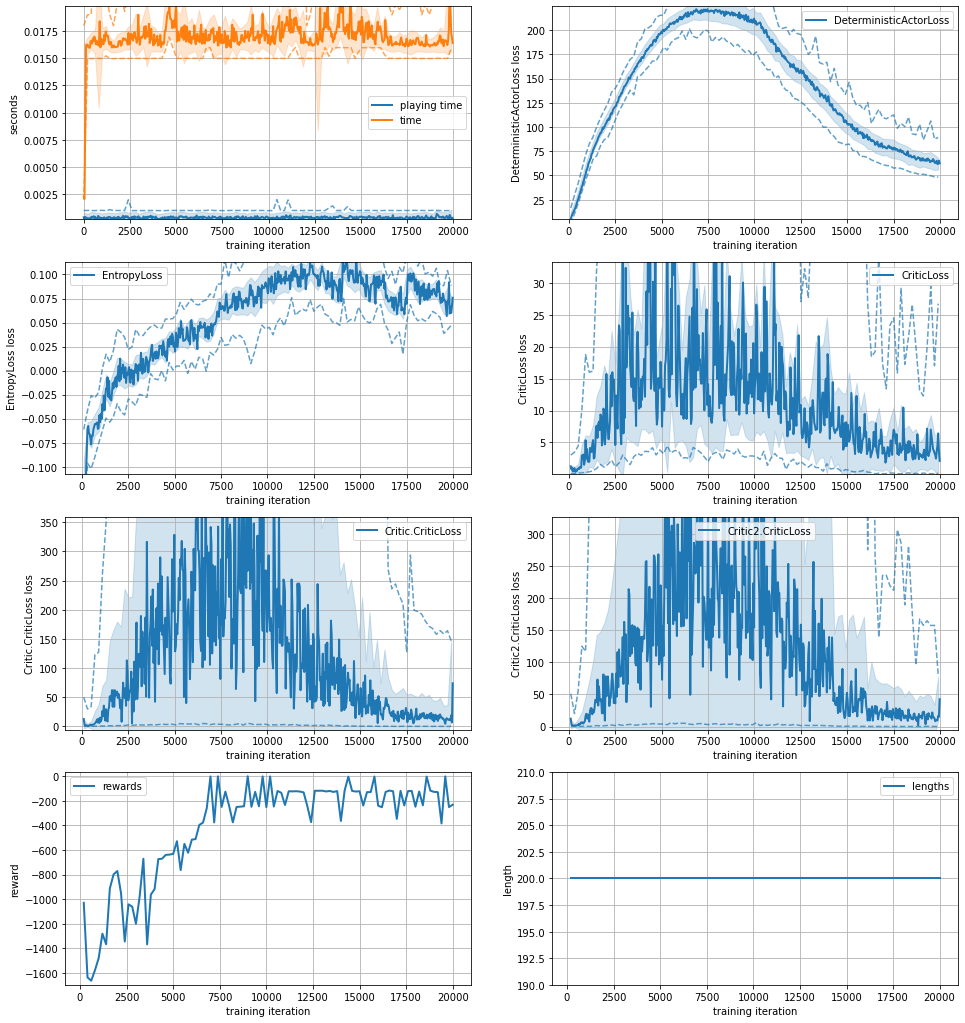

In [41]:
sac.run(20000)

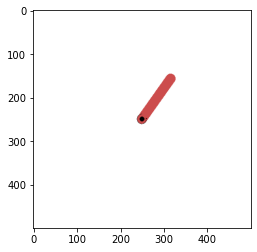

In [44]:
sac.runner.play(sac.policy.act, render=True);

In [45]:
sac.runner.fps

58.88306448183017